<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [79]:
import cv2
import torch
import matplotlib.pyplot as plt

import multiprocessing as mp

import geopandas as gpd
import rasterio
from shapely import geometry
import numpy as np

from tqdm.auto import tqdm
from skimage.morphology import h_minima, watershed, label

from dh_segment_torch.inference import InferenceModel

In [80]:
model_classes = InferenceModel.from_params({
        "model": {
            "encoder": "resnet50",
            "decoder": {"decoder_channels": [512, 256, 128, 64, 32], "max_channels": 512}
        },
        "num_classes": 6,
        "model_state_dict": "/home/laini/cadaster_1848_geom/best_model_checkpoint_classes_inv_miou=0.445.pth",
        "device": "cuda:4",
        "patch_size": (500,500),
    "patches_batch_size": 8,
    "patches_overlap": 0.2,
    "multilabel": False
})


In [81]:
model_edges = InferenceModel.from_params({
        "model": {
            "encoder": "resnet50",
            "decoder": {"decoder_channels": [512, 256, 128, 64, 32], "max_channels": 512}
        },
        "num_classes": 2, 
        "multilabel": False, 
        "device": "cuda:4",
        "patch_size": (500,500), 
    "patches_batch_size": 8,
    "patches_overlap": 0.2,
            "model_state_dict": "/home/laini/best_model_edge3_checkpoint_miou=0.705.pth",

})

In [82]:
img = cv2.imread('/dhlabdata4/laini/cadaster_1848_test/cannaregio_08.tif')[:,:,::-1].copy() # lit l'image en RGB

In [83]:
img_torch = torch.from_numpy(img[1000:4000,3000:6000].transpose(2,0,1)/255).float().unsqueeze(0) # transforme en pytorch

In [84]:
probs_edges = model_edges.predict_patches(img_torch)[0] 

probs_classes = model_classes.predict_patches(img_torch)[0]

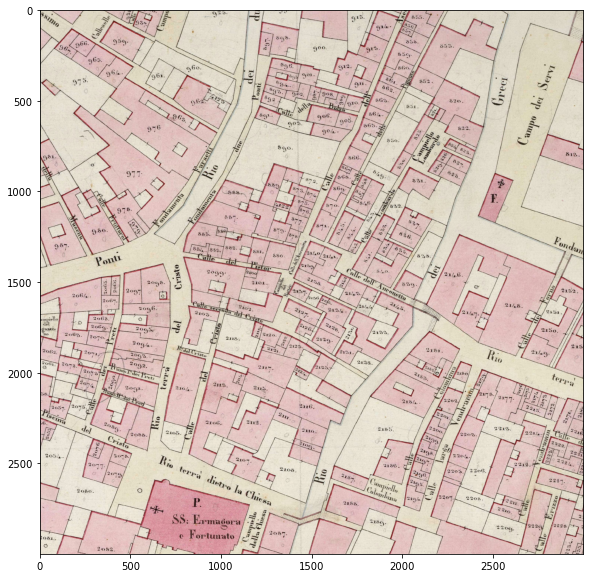

In [85]:
plt.figure(figsize=(10,10))
plt.imshow(img[1000:4000,3000:6000])

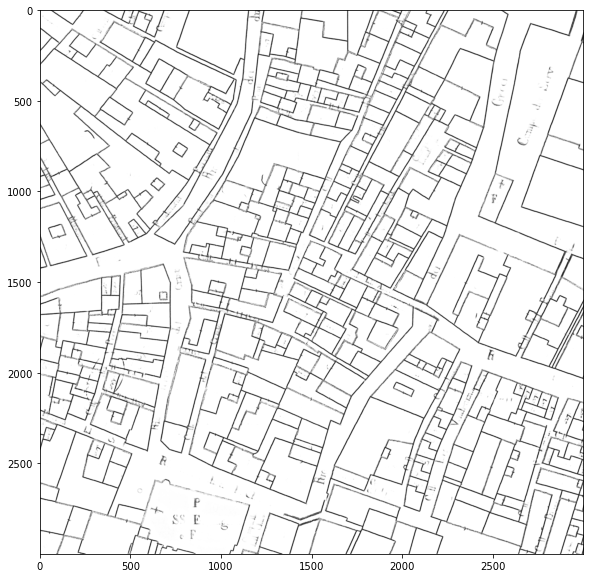

In [86]:
plt.figure(figsize=(10,10))
plt.imshow(probs_edges.cpu().numpy()[0], cmap='gray')

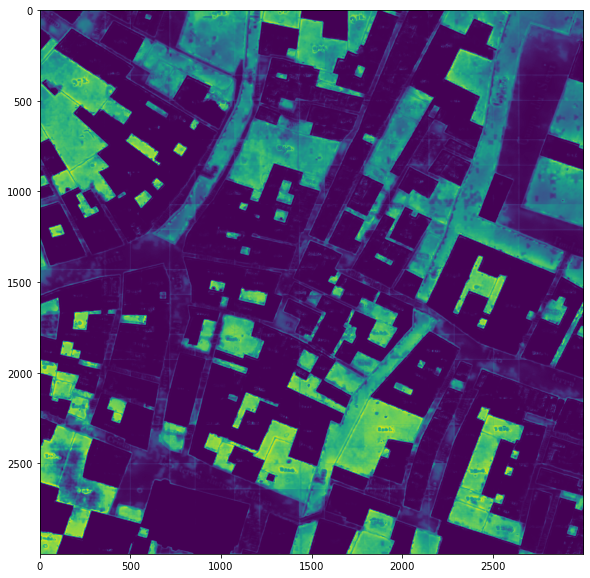

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(probs_classes.cpu().numpy()[4])

In [88]:
#countours = probs_classes.cpu().numpy()[0]

countours = probs_edges.cpu().numpy()[1]

minimas = label(h_minima(countours, 0.1))

watershed_parcels = watershed((255 * countours).astype('int'), minimas)

Text(0.5, 1.0, 'Watershed parcels')

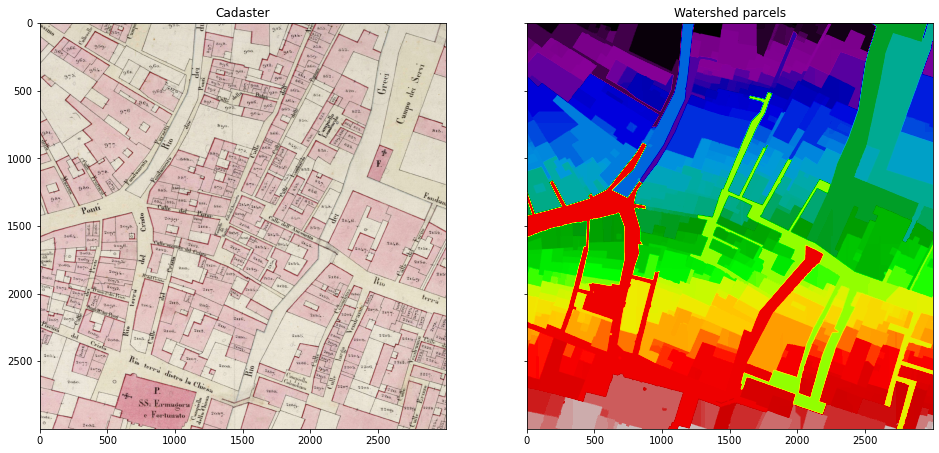

In [89]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img[1000:4000,3000:6000], cmap=plt.cm.gray)
ax[0].set_title('Cadaster')

ax[1].imshow(watershed_parcels, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Watershed parcels')

In [90]:
idx2class = dict(enumerate(['street', 'water', 'church', 'courtyard', 'building']))
num_parcels= np.unique(watershed_parcels)

In [91]:
transform = rasterio.open('/dhlabdata4/laini/cadaster_1848_test/cannaregio_08.tif').transform

In [92]:
def num_parcel2res(parcel_idx):
    mask_parcel = watershed_parcels == parcel_idx
    class_idx = np.bincount(probs_classes.cpu()[1:, mask_parcel].argmax(axis=0)).argmax()
    contours, hierarchy = cv2.findContours(mask_parcel.astype('uint8').copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    poly1 = (cv2.approxPolyDP(contours[0], 1, closed=True)[:,0,:]).tolist()
    poly1.append(poly1[0])
    poly1 = [transform*x for x in poly1]
    holes = []
    for h in contours[1:]:
        poly2 = (cv2.approxPolyDP(h, 1, closed=True)[:,0,:]).tolist()
        poly2.append(poly2[0])
        poly2 = [transform*x for x in poly2]
        holes.append(poly2)
    poly = geometry.Polygon(poly1, holes=holes)
    return poly, idx2class[class_idx]

In [93]:
results = []

for idx in tqdm(num_parcels):
    results.append(num_parcel2res(idx))
    
all_polys = [x[0] for x in results]
all_classes = [x[1] for x in results]

all_polys = gpd.GeoSeries(all_polys)
all_polys.crs = 'EPSG:3004'

In [94]:
geodata = all_polys.to_frame('geometry')

In [95]:
geodata['class'] = all_classes

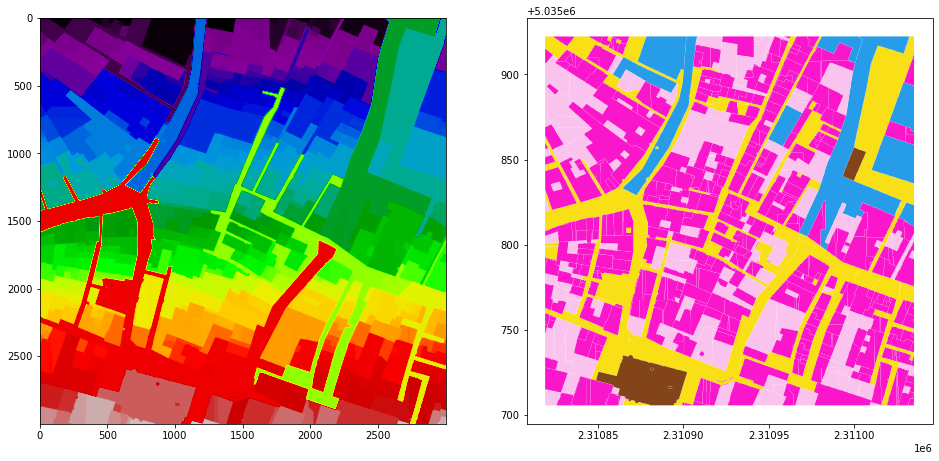

In [105]:
palette = ['#F9DF16','#279CE9','#844419','#F9C3EE','#F916CB']
fig, axes = plt.subplots(ncols=2,figsize = (16,8))
ax = axes.ravel()
for idx, label in idx2class.items():
    geodata.loc[geodata['class'] == label]['geometry'].plot(color=palette[idx], label=label, ax=ax[1])
ax[0].imshow(watershed_parcels, cmap=plt.cm.nipy_spectral)

In [98]:
geodata.to_file('extraction_cannaregio8_test9.geojson', driver='GeoJSON')